<a href="https://colab.research.google.com/github/SunithAreng/fydp_team14/blob/sunith/Machine_Learning_Pipeline_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries and CSV file

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

In [ ]:
houses = pd.read_csv("house_sigma_raw_exploded.csv")

In [ ]:
# prompt: print all the column names one by one
houses.dropna(axis=1, how='all', inplace=True)

#drop rows where listed is missing
houses.dropna(subset=['listed'], inplace=True)

In [ ]:
print(len(houses))
print(len(houses.columns))

687
176


In [ ]:
# Count non-NaN values in each column
value_counts = houses.count()

# Identify columns with less than 10 non-NaN values
columns_to_drop = value_counts[value_counts < 10].index

# Drop the identified columns
houses.drop(columns=columns_to_drop, inplace=True)

# Display info to confirm changes
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687 entries, 0 to 870
Columns: 105 entries, listing to association_fee
dtypes: float64(21), object(84)
memory usage: 568.9+ KB


In [ ]:
# prompt: separate out the columns which are numbers and the ones which are object (string)

numeric_cols = houses.select_dtypes(include=np.number).columns
object_cols = houses.select_dtypes(include=object).columns

In [ ]:
numeric_features = ['rooms', 'bedrooms', 'bedrooms_above_ground',
                'bedrooms_below_ground', 'bathrooms', '2_piece_bathrooms',
                '3_piece_bathrooms', '4_piece_bathrooms', 'garage',
                'frontage_length', 'depth', 'fireplace_total']

numeric_features convert numeric_features in the houses df into a float type

In [ ]:
for col in numeric_features:
    houses[col] = pd.to_numeric(houses[col], errors='coerce')
    houses[col] = houses[col].astype(float)

create a new column called "house_year", where you will take the "year_built" and if "year_built" is none then take building_age


In [ ]:
def calculate_house_age(year_string):
    if '-' in str(year_string):
        try:
            start, end = map(int, year_string.split('-'))
            return (start + end) / 2
        except ValueError:
            return None  # Handle cases where splitting fails
    elif str(year_string).isdigit() and len(str(year_string)) == 4:
        try:
            return 2025 - int(year_string)
        except ValueError:
            return None
    else:
        return None

In [ ]:
houses['house_year'] = houses['year_built'].fillna(houses['building_age'])
houses['house_age'] = houses['house_year'].apply(calculate_house_age)

Number of None values in 'house_age': 197


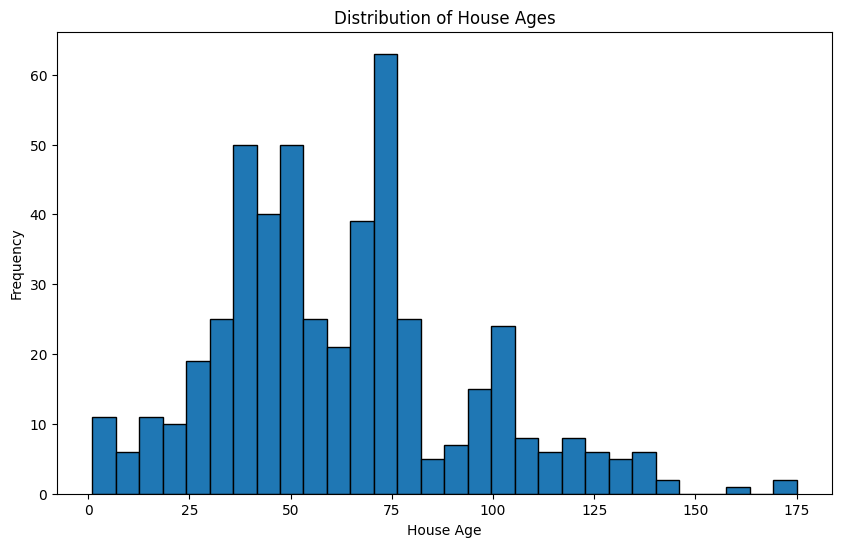

In [ ]:
# prompt: generate a histogram with house_age and plot it show. do a count for the ones with none

import matplotlib.pyplot as plt

# Calculate the count of None values in 'house_age'
none_count = houses['house_age'].isnull().sum()
print(f"Number of None values in 'house_age': {none_count}")

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(houses['house_age'].dropna(), bins=30, edgecolor='black')  # Drop NaN values for plotting
plt.xlabel('House Age')
plt.ylabel('Frequency')
plt.title('Distribution of House Ages')
plt.show()


fill na in house_age with the average of the house_age column

In [ ]:
# Calculate the average house age, excluding NaN values
average_house_age = houses['house_age'].mean()

# Fill NaN values in 'house_age' with the average house age
houses['house_age'].fillna(average_house_age, inplace=True)

# Verify the changes (optional)
print(houses['house_age'].isnull().sum()) # Should print 0

0


<ipython-input-57-ac693792b147>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  houses['house_age'].fillna(average_house_age, inplace=True)


## Create ML Dataframes

In [ ]:
# Create a separate DataFrame with numeric columns and 'listing_id'
ml_houses = houses.select_dtypes(include=np.number)
ml_houses['listing_id'] = houses['listing_id']
ml_houses['price'] = houses['listed']
ml_houses['listing'] = houses['listing']

# Convert 'price' column to numeric, handling '$' and ','
ml_houses['price'] = ml_houses['price'].astype(str).str.replace(r'[$,]', '', regex=True)
ml_houses['price'] = pd.to_numeric(ml_houses['price'], errors='coerce')

In [ ]:
# place listing_id as the first column in the df

# Get the current column order
cols = ml_houses.columns.tolist()

# Move 'listing_id' to the first position
cols.insert(0, cols.pop(cols.index('listing_id')))

# Reorder the DataFrame
ml_houses = ml_houses.reindex(columns=cols)

In [ ]:
# Reset the index of the DataFrame
ml_houses = ml_houses.reset_index(drop=True)
ml_houses.head(5)

,listing_id,rooms,bedrooms,bedrooms_above_ground,bedrooms_below_ground,beds_on_level_second,bathrooms,full_bathrooms,half_bathrooms,2_piece_bathrooms,...,laundries_on_level_lower,parking_places,beds_on_level_third,baths_on_level_third,laundries_on_level_main,laundries_on_level_second,association_fee,house_age,price,listing
0,40659393,9.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.229592,639000.0,"A - 688 Highpoint Avenue , Waterloo"
1,40642222,10.0,4.0,3.0,1.0,NaN,2.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.229592,795000.0,"209 Rodney Street , Waterloo"
2,40666320,9.0,3.0,3.0,0.0,2.0,2.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000,650000.0,"8 Mckenzie Avenue , Kitchener - Auditorium"
3,40667232,11.0,3.0,3.0,0.0,NaN,2.0,2.0,0.0,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,834900.0,"351 Thorncrest Drive , Waterloo"
4,40671544,11.0,3.0,3.0,0.0,3.0,2.0,2.0,0.0,0.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,61.000000,699900.0,"537 Drummerhill Crescent , Waterloo"


## Feature Engineering
We are going to columns which we think has relevant features and un-nest them if we can do a one-hot encoding. (Currently this is the best method, but we can work on this).

In [ ]:
print(object_cols)

Index(['listing', 'type', 'listed', 'sold', 'listing_id', 'sold_date',
       'ai_summary', 'description', 'tax', 'parking', 'listing_#',
       'data_source', 'days_on_market', 'property_days_on_market',
       'status_change', 'listed_on', 'updated_on', 'year_built',
       'property_type', 'style', 'frontage_type', 'community', 'municipality',
       'appliances_included', 'appliances_excluded', 'rooms', 'bedrooms',
       'bedrooms_above_ground', 'bedrooms_below_ground', 'bathrooms',
       '2_piece_bathrooms', '3_piece_bathrooms', '4_piece_bathrooms',
       'laundry_features', 'cooling', 'heating', 'water', 'size',
       'architecture_style', 'direction', 'roof', 'construction',
       'foundation_type', 'driveway_parking', 'garage', 'lot_features',
       'farm_land_area_units', 'sewer', 'frontage_length', 'depth', 'lot_size',
       'acreage', 'zoning', 'feature', 'fireplace', 'exterior_feature',
       'parking_features', 'building_age', 'security', 'fireplace_total',
       

In [ ]:
# prompt: show all the unique values in houses['lot_features']

# print(houses['appliances_included'].unique())

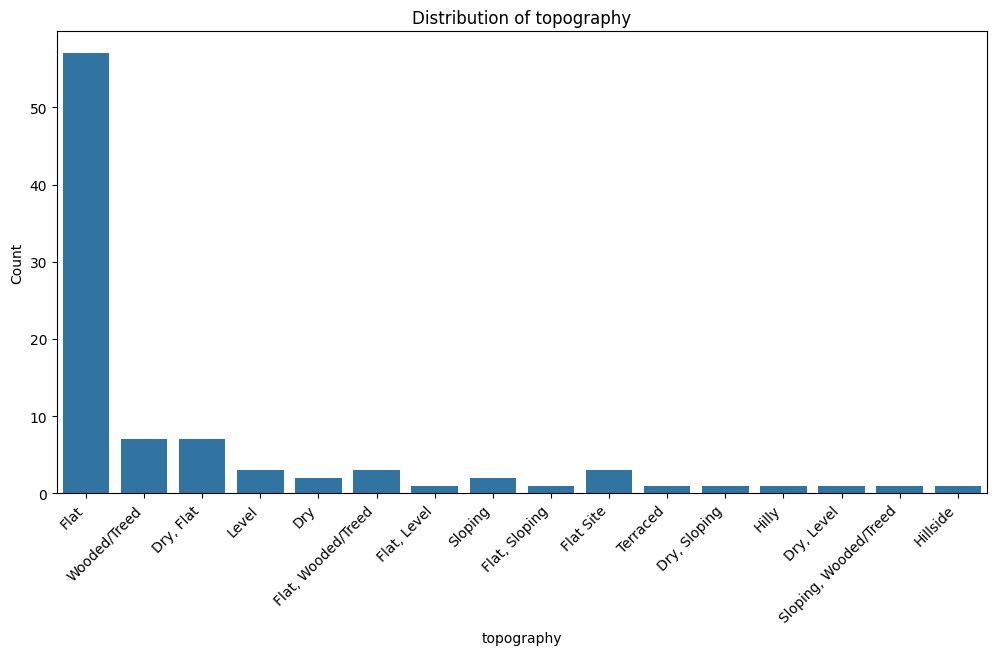

In [ ]:
# quick plot and visualize a column that you would like to encode for its feasibility

column_name = 'topography'

plt.figure(figsize=(12, 6))
sns.countplot(data=houses, x=column_name)
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.show()

Based on the above EDA, we will now insert these into "columns_to_encode" array. These arrays will be spilt on commas in their values and will be one-hot encoded. The split exceptions are just labels which won't be split but will be encoded since each record is repeated (finite classes).  

## Encoding for Training

In [ ]:
columns_to_encode = ['architecture_style','property_type',
                     'driveway_parking', 'frontage_type',
                     'sewer', 'bathrooms_detail', 'lot_features',
                     'topography', 'exterior_feature', 'basement_type',
                     'roof', 'waterfront_features', 'appliances_included',
                     'laundry_features', 'topography',
                     ]
split_exceptions = ['bathrooms_detail',]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
def one_hot_encode_column(column):
    if column not in split_exceptions:
      houses[f'{column}_arr'] = houses[column].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    else:
      houses[f'{column}_arr'] = houses[column].apply(lambda x: [x] if isinstance(x, str) else [])

    mlb = MultiLabelBinarizer()
    encoded_data = mlb.fit_transform(houses[f'{column}_arr'])
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_)

    # Add column variable as suffix to encoded column names
    encoded_df = encoded_df.add_suffix(f'_{column}')

    return encoded_df

In [ ]:
# TODO: Appliances Excluded has to be penalizing in giving value to the prices

In [ ]:
for column in columns_to_encode:
    encoded_df = one_hot_encode_column(column)
    ml_houses = pd.concat([ml_houses, encoded_df], axis=1)

In [ ]:
print(len(ml_houses))


687
995


In [ ]:
import re
# Drop columns containing "none" case-insensitive
ml_houses = ml_houses.drop(columns=[col for col in ml_houses.columns if re.search(r"none", col, re.IGNORECASE)])

# Drop columns with '*' in their names
ml_houses = ml_houses.drop(columns=[col for col in ml_houses.columns if '*' in col])
ml_houses = ml_houses.fillna(0)
print(len(ml_houses.columns))

980


In [ ]:
features = ml_houses.drop(columns=['listing_id', 'price', 'listing'])
price = ml_houses['price']
print(len(price))
print(len(features))

687
687


In [ ]:
# prompt: get a table of where correlating columns are put side by side along with their scores. And sort them in descending order.

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Remove diagonal part
correlation_matrix = correlation_matrix.mask(np.equal(*np.indices(correlation_matrix.shape)))

# Stack the correlation matrix
corr_pairs = correlation_matrix.stack()

# Sort by absolute value
sorted_pairs = corr_pairs.abs().sort_values(ascending=False)

# Get the top n pairs (adjust n as needed)
top_n_pairs = sorted_pairs.head(20)  # Example: top 20 pairs

# Create a DataFrame for the results
correlation_table = pd.DataFrame({
    'Column1': top_n_pairs.index.get_level_values(0),
    'Column2': top_n_pairs.index.get_level_values(1),
    'CorrelationScore': top_n_pairs.values
})
# correlation_table

In [ ]:
# prompt: Using dataframe correlation_table: take rows where the correlation score is greater than 0.8. then in that subset, take column 1 and all the unique names in that small subset. then drop these columns from the features table

# Filter the correlation table to include only rows where the correlation score is greater than 0.8
filtered_correlation = correlation_table[correlation_table['CorrelationScore'] > 0.8]

# Get the unique names from 'Column1' in the filtered table
col1_names = filtered_correlation['Column1'].unique()

# Assuming 'features' is another DataFrame where you want to drop the columns
# Replace 'features' with your actual DataFrame name if it's different
# Drop the specified columns from the features table
# Note that if any of the columns in col1_names do not exist in the features table,
# a KeyError will occur. You may consider adding a try-except block to handle the error gracefully
# or use the errors='ignore' parameter in the drop function.

try:
    features = features.drop(columns=col1_names)
    print("Columns dropped successfully.")
except KeyError as e:
    print(f"Error: Column(s) {e} not found in the features DataFrame.")

# Print the resulting features DataFrame (Optional)
# print(features.head())

Columns dropped successfully.


In [ ]:
# prompt: 'kitchens', 'rooms', 'bathrooms' drop these three columns from features dataframe

# Drop 'kitchens', 'rooms', and 'bathrooms' columns if they exist
columns_to_drop = ['kitchens', 'rooms', 'bathrooms', 'bedrooms']
for col in columns_to_drop:
    if col in features.columns:
        features = features.drop(columns=[col])
    else:
        print(f"Warning: Column '{col}' not found in features DataFrame.")

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Columns: 966 entries, bedrooms_above_ground to Wooded/Treed_topography
dtypes: float64(30), int64(936)
memory usage: 5.1 MB


In [ ]:
from sklearn.model_selection import train_test_split

# Set random state for reproducibility.
seed = 100
test_size = 0.2

# Split data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=test_size, random_state=seed)

In [ ]:
X_train.head()

,bedrooms_above_ground,bedrooms_below_ground,beds_on_level_second,full_bathrooms,half_bathrooms,2_piece_bathrooms,3_piece_bathrooms,4_piece_bathrooms,5_plus_piece_bathrooms,baths_on_level_basement,...,Wooded/Treed_topography,Dry_topography,Flat_topography,Flat Site_topography,Hillside_topography,Hilly_topography,Level_topography,Sloping_topography,Terraced_topography,Wooded/Treed_topography
203,3.0,0.0,3.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
636,3.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
528,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
544,3.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
616,3.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# prompt: create a ml model with random forest and train on above sets and predict and evaluate

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)  # You can adjust n_estimators
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 101774528860.55673
Root Mean Squared Error (RMSE): 319021.20440584625
R-squared (R2): -0.10929953901447265


In [ ]:
# prompt: create a linear regression model and train on the above sets and predict

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 492194328575.3375
R-squared: -4.364711071688995


In [ ]:
# prompt: keep the predicted and price in one df and create a third column with the calculated error

# Create a DataFrame with predicted and actual prices
results_df = pd.DataFrame({'predicted_price': y_pred, 'actual_price': y_test})

# Calculate the error
results_df['error'] = results_df['predicted_price'] - results_df['actual_price']

# Display the DataFrame
results_df

,predicted_price,actual_price,error
40,7.510577e+05,599000.0,1.520577e+05
421,-4.708857e+04,599900.0,-6.469886e+05
198,7.863228e+05,699000.0,8.732283e+04
103,6.189291e+05,774900.0,-1.559709e+05
355,1.189374e+06,600000.0,5.893744e+05
...,...,...,...
479,-4.996525e+05,699000.0,-1.198652e+06
661,6.834158e+05,649900.0,3.351579e+04
600,1.549240e+06,1000000.0,5.492399e+05
670,1.055309e+06,699999.0,3.553096e+05


In [ ]:
feature_names = X_test.columns.tolist()
feature_weights = model.coef_
# for feature, weight in zip(feature_names, feature_weights):
#     print(f"{feature}: {weight}")


In [ ]:
# prompt: get the coefficents for the weights in rf_model

feature_names = X_test.columns.tolist()
feature_weights = rf_model.feature_importances_
# for feature, weight in zip(feature_names, feature_weights):
#     print(f"{feature}: {weight}")


In [ ]:
percentages = feature_weights * 100

The following applies only to linear regression

In [ ]:
coefficients = model.coef_

In [ ]:
# Convert coefficients to absolute values and normalize to percentages
absolute_coefficients = np.abs(coefficients)
percentages = (absolute_coefficients / np.sum(absolute_coefficients)) * 100

In [ ]:
# Combine feature names and percentages, then sort by percentages in descending order
sorted_features = sorted(zip(feature_names, percentages), key=lambda x: x[1], reverse=True)

# Select the top 20 features
top_features = sorted_features[:20]
top_feature_names, top_percentages = zip(*top_features)


## The following only shows overall for the market

This is why we are seeing frontage types several times


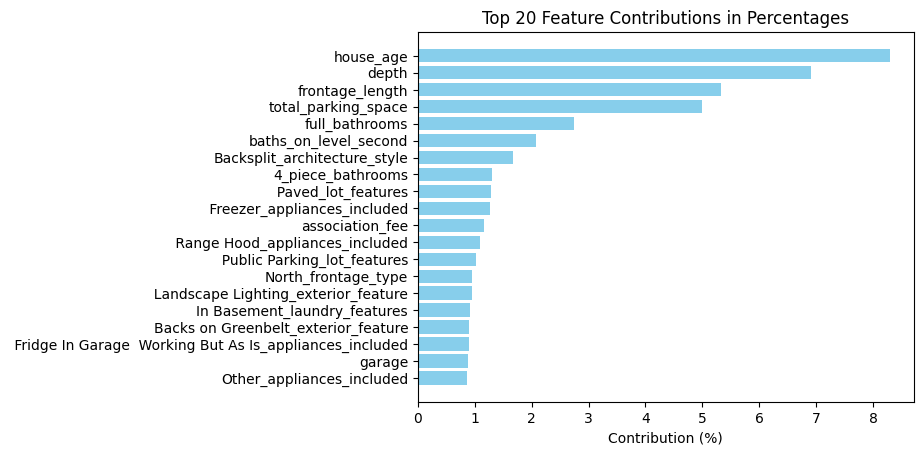

In [ ]:
# Visualize as a bar chart
plt.barh(top_feature_names, top_percentages, color='skyblue')
plt.xlabel("Contribution (%)")
plt.title("Top 20 Feature Contributions in Percentages")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest contribution at the top
plt.show()

## Implementing to predict

In [ ]:
# prompt: take a single data point from test set and apply the model to give a prediction

# Assuming X_test and model are defined from the previous code

# Select a single data point from the test set (e.g., the first one)
single_data_point = X_test.iloc[[0]]

# Apply the model to the single data point
prediction = rf_model.predict(single_data_point)

print(f"Prediction for the selected data point: {prediction[0]}")


Prediction for the selected data point: 710776.98


In [ ]:
single_data_point

,bedrooms_above_ground,bedrooms_below_ground,beds_on_level_second,full_bathrooms,half_bathrooms,2_piece_bathrooms,3_piece_bathrooms,4_piece_bathrooms,5_plus_piece_bathrooms,baths_on_level_basement,...,Wooded/Treed_topography,Dry_topography,Flat_topography,Flat Site_topography,Hillside_topography,Hilly_topography,Level_topography,Sloping_topography,Terraced_topography,Wooded/Treed_topography
40,3.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ml_houses.iloc[40]['listing']

'556 Frederick Street , Kitchener - Rosemount'

In [ ]:
y_test.iloc[[0]]


,price
40,599000.0


In [ ]:
# Convert the single data point to an ndarray
single_data_point_array = single_data_point.values

# Maintain the order of columns
column_order = X_test.columns.tolist()

In [ ]:
output = np.multiply(coefficients , single_data_point_array) # this is for linear regression

In [ ]:
price_ndarray = ml_houses['price'].values

In [ ]:
# Convert X_train to a NumPy ndarray
X_train_ndarray = X_train.values

In [ ]:
# Calculate standard deviations
std_y = np.std(price_ndarray)
std_X = np.std(X_train_ndarray, axis=0)

importances = rf_model.feature_importances_

# Convert feature importances to weights
weights = importances * (std_y / std_X)

# print("Feature importances:", importances)
# print("Weights (scaled):", weights)

<ipython-input-222-c530e117cb9e>:8: RuntimeWarning: divide by zero encountered in divide
  weights = importances * (std_y / std_X)
<ipython-input-222-c530e117cb9e>:8: RuntimeWarning: invalid value encountered in multiply
  weights = importances * (std_y / std_X)


In [ ]:
weights

array([2.58722003e+03, 2.66341071e+03, 1.31327821e+03, 9.01568395e+03,
       1.98112548e+03, 1.17964266e+03, 2.61136490e+03, 6.00734183e+03,
       2.98636829e+03, 2.88116858e+03, 7.64676321e+03, 3.99909800e+03,
       1.03147828e+03, 3.02826568e+03, 2.18859068e+03, 3.37384018e+03,
       8.08412879e+03, 7.35132777e+02, 3.51862235e+02, 2.06424433e+03,
       1.50805369e+03, 3.45489194e+03, 1.38590197e+03, 8.90803646e+02,
       2.80665589e+03, 3.05771457e+03, 4.12886679e+03, 6.39483518e+02,
       7.07219963e+01, 9.81784117e+02, 1.78940970e+03, 2.15030612e+02,
       2.72971433e+03, 2.46351068e+04, 3.69525191e+01, 1.36611852e+03,
       1.61657999e+03, 3.00667523e+03, 4.92565424e+00, 3.30112678e+03,
       2.98547389e+03, 8.43452634e+02, 3.19019655e+03, 4.43230277e+01,
       3.87846363e+03, 8.12739779e+02, 2.52115046e+03, 3.16735928e+00,
       1.15870589e+01, 4.32769632e+03, 9.54843520e+03, 6.63707351e+01,
       3.64042317e+02, 1.42663912e+03, 4.31201919e+03, 8.71516982e+02,
      

In [ ]:
output = np.multiply(weights , single_data_point_array) # this is for random forest

In [ ]:
# prompt: in the output variable above cell replace na with 0

output = np.nan_to_num(output)

In [ ]:
output

array([[ 7761.66009303,     0.        ,  3939.83462698,  9015.68395383,
            0.        ,     0.        ,     0.        ,  6007.34183114,
            0.        ,     0.        ,  7646.76321316,  3999.09800421,
            0.        ,     0.        ,     0.        ,     0.        ,
        16168.25757632, 22090.73995752, 35242.52144208,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        , 46143.85352063,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,  3301.12677969,
         2985.47389216,     0.        ,     0.        ,     0.        ,
         3878.46363469,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.  

In [ ]:
# prompt: lets map column_order with output, to show column_name with the results of output as weights. Store it as a df

# Create a DataFrame to store the column order and output weights
df_output = pd.DataFrame({'column_name': column_order, 'weights': output[0]})

# Display the DataFrame
df_output


,column_name,weights
0,bedrooms_above_ground,7761.660093
1,bedrooms_below_ground,0.000000
2,beds_on_level_second,3939.834627
3,full_bathrooms,9015.683954
4,half_bathrooms,0.000000
...,...,...
961,Hilly_topography,0.000000
962,Level_topography,0.000000
963,Sloping_topography,0.000000
964,Terraced_topography,0.000000


In [ ]:
absolute_coefficients_y = np.abs(output[0])
percentages_y = (absolute_coefficients_y / np.sum(absolute_coefficients_y)) * 100
# percentages_y = rf_model.feature_importances_ * 100

In [ ]:
# Combine feature names and percentages, then sort by percentages in descending order
sorted_features_y = sorted(zip(column_order, percentages_y), key=lambda x: x[1], reverse=True)

# Select the top 20 features
top_features_y = sorted_features_y[:20]
top_feature_names_y, top_percentages_y = zip(*top_features_y)

In [ ]:
# prompt: create a dataframe with top_feature_names_y, top_percentages_y

# Create a DataFrame with top_feature_names_y and top_percentages_y
top_features_df = pd.DataFrame({'feature': top_feature_names_y, 'percentage': top_percentages_y})
top_features_df


,feature,percentage
0,house_age,22.632866
1,depth,17.285927
2,frontage_length,10.835176
3,total_parking_space,7.930287
4,full_bathrooms,4.422057
5,bedrooms_above_ground,3.806978
6,baths_on_level_second,3.750622
7,4_piece_bathrooms,2.946511
8,Park_lot_features,2.769192
9,kitchens_above_ground,1.961497


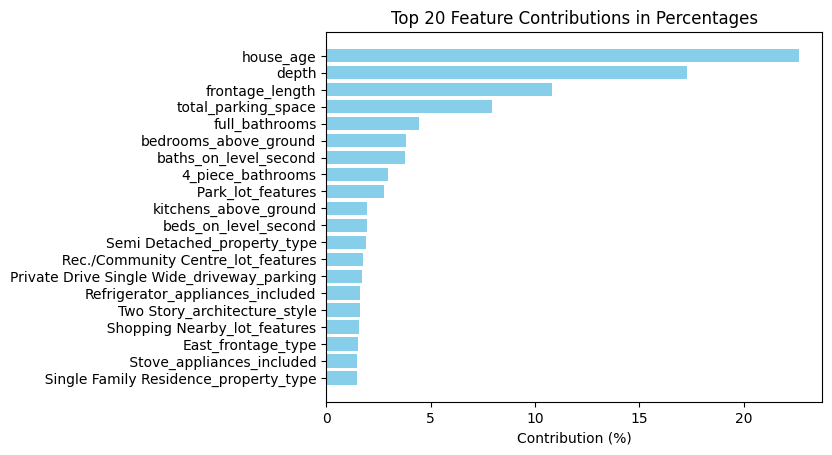

In [ ]:
# Visualize as a bar chart
plt.barh(top_feature_names_y, top_percentages_y, color='skyblue')
plt.xlabel("Contribution (%)")
plt.title("Top 20 Feature Contributions in Percentages")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest contribution at the top
plt.show()